실습 하기에 앞서 텐서플로우 2.x설치

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf #텐서플로우 2.x 실행 

In [2]:
tf.__version__

'2.2.0'

##1. 랜덤으로 만든 시계열 데이터 연습(Many-to-one)

RNN은 일반적으로 시간 순서가 정해진 일명, 시계열 데이터를 분석하기에 적합한 인공신경망입니다.  
데이터 간에 순서에 따라 의미가 달라진다면, 데이터를 순서에 맞춰 학습시키는 것이 효과적일 것입니다.  
Recurrent Neural Networks가 바로 이에 적합한 구조입니다.

###1-1 단층 Simple RNN으로 데이터 실습

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

RNN은 입력 sequence의 길이와 출력 sequence의 길이에 따라, Many-to-one, Many-to-Many, one-to-Many 등이 있습니다.  
  
학습하는 방식은 크게 다르지 않습니다.  
먼저, Many-to-one 예제 데이터를 직접 생성하여 실습을 진행해보겠습니다.  

np.sin함수와 np.arange함수, np.random.random함수를 사용해 랜덤한 파형 그래프를 그리는 데이터를 생성하겠습니다.   

In [6]:
data = np.sin(2*np.pi*np.arange(0, 1000))*10 + np.random.random(1000)
data.shape

(1000,)

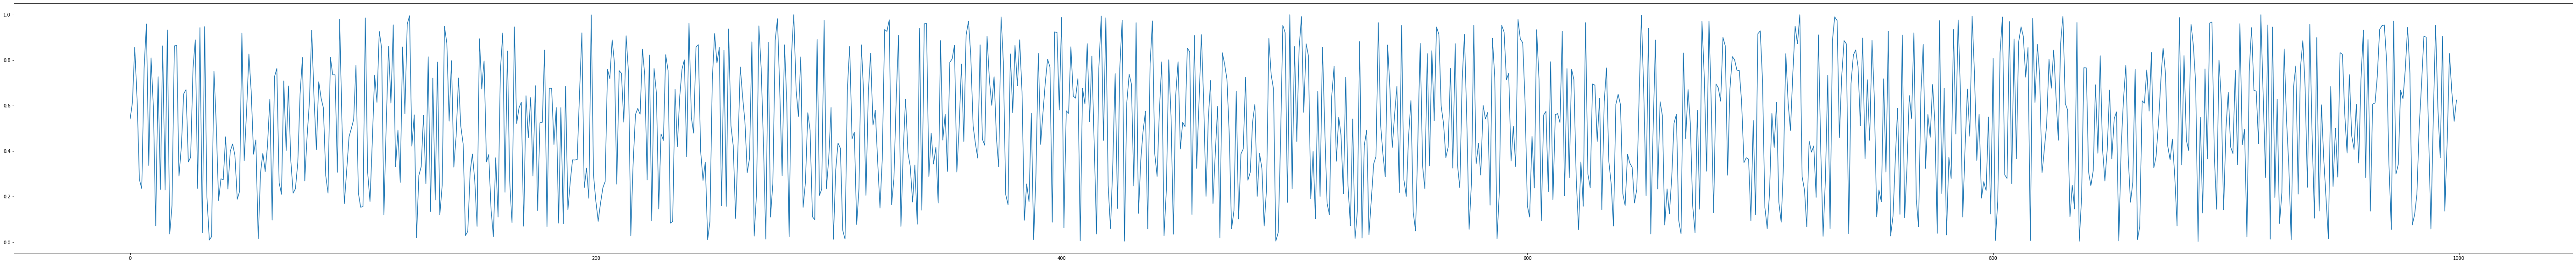

In [7]:
plt.figure(figsize=[100, 10])
plt.plot(np.arange(0, 1000), data)
plt.show()

다음으로, 해당 샘플 데이터를 1칸씩 이동하며 10개씩 데이터를 잘라, x값으로 사용하고, y값은 11번째 데이터로 사용하겠습니다.  
예) x = 1번째 ~ 10번째 데이터 / y = 11번째

질문) 길이가 1000인 data를 이용해, 몇 쌍의 x, y 데이터를 만들어낼 수 있을까요?


In [8]:
x_sin = np.array([[[data[i+j]] for j in range(10)] for i in range(len(data)-9-1)])
y_sin = np.array([[data[i+10]] for i in range(len(data)-10)])
x_sin.shape, y_sin.shape

((990, 10, 1), (990, 1))

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_sin, y_sin, shuffle=False) # shuffle = False로 명시하면, 데이터셋 순차적으로 split

RNN은 모델은 크게 SimpleRNN, LSTM, GRU 모델이 있습니다.  

가장 기본이 되는 SimpleRNN부터 살펴보겠습니다.  
RNN layer를 사용할 때 주요 parameter는 두가지입니다.  
1) units = hidden_layer(Memory Cell)의 node 개수입니다.  
2) return_sequences = output Shape으로 sequence의 길이를 포함할지 말지를 정하기 위한 파라미터입니다. -> hidden_layer를 다층으로 연결하려면 True로 줘야합니다.  



In [10]:
layers.Dense?

In [11]:
model = models.Sequential() #모델 호출
model.add(layers.SimpleRNN(units=8,input_shape = (10,1), name='SimpleRNN-1')) # RNN 호출
model.add(layers.Dense(1, name='hidden-to-output')) # 출력을 위한 FFN

model.compile(optimizer='adam',loss='mse')
model.fit(x_train,y_train,epochs=5,verbose=1)

Epoch 1/5
24/24 [==============================] - 0s 9ms/step - loss: 0.2299
Epoch 2/5
24/24 [==============================] - 0s 8ms/step - loss: 0.1357
Epoch 3/5
24/24 [==============================] - 0s 7ms/step - loss: 0.1160
Epoch 4/5
24/24 [==============================] - 0s 7ms/step - loss: 0.1061
Epoch 5/5
24/24 [==============================] - 0s 7ms/step - loss: 0.1008


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SimpleRNN-1 (SimpleRNN)      (None, 8)                 80        
_________________________________________________________________
hidden-to-output (Dense)     (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.predict(x_train).shape

(742, 1)

In [14]:
for model_weight in model.weights:
    print(model_weight.name, ' => ', model_weight.shape)

SimpleRNN-1/simple_rnn_cell/kernel:0  =>  (1, 8)
SimpleRNN-1/simple_rnn_cell/recurrent_kernel:0  =>  (8, 8)
SimpleRNN-1/simple_rnn_cell/bias:0  =>  (8,)
hidden-to-output/kernel:0  =>  (8, 1)
hidden-to-output/bias:0  =>  (1,)


In [ ]:
y_hat = model.predict(x_test) #테스트 값 예측

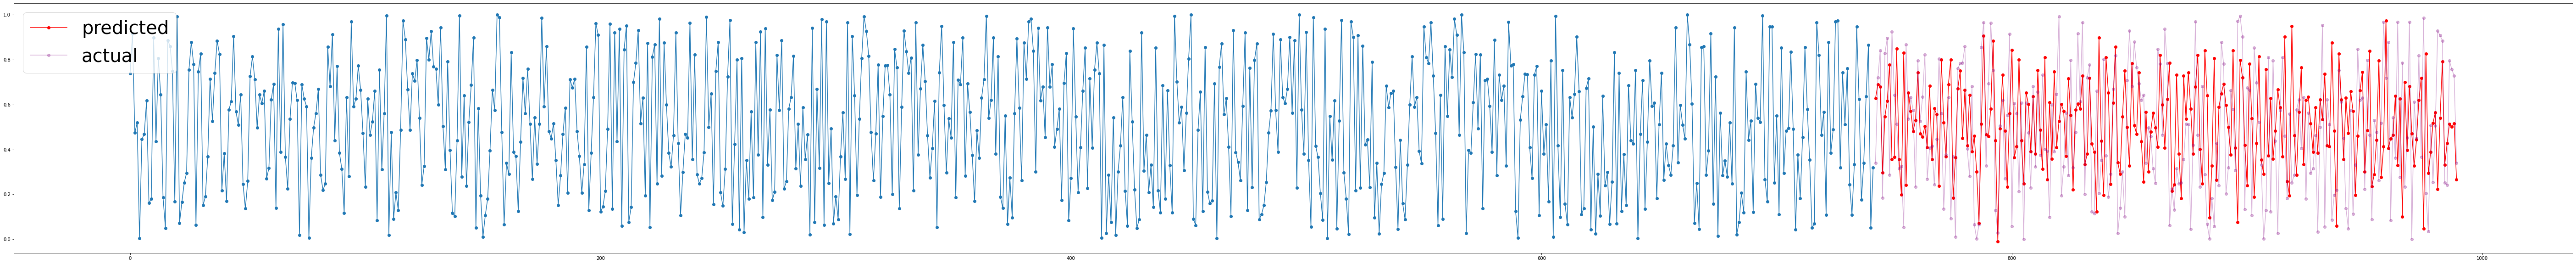

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') #Train데이터 그래프로 표현
plt.plot(y_2_axis, y_hat.reshape(len(x_test),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test.reshape(len(x_test),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=40)
plt.show()

### 1-2 다층 SimpleRNN 실습 
이번엔 SimpleRNN layer를 추가해봅시다.  
핵심 개념은 layer의 깊이와 Sequence의 길이를 헷갈리지 않는 것입니다.  
위에서 살펴본 단층 SimpleRNN은 layer의 깊이는 1이고, Sequence의 길이가 10입니다.  
이번에는 SimpleRNN의 layer의 깊이를 3으로 높여봅시다.

In [ ]:
model = models.Sequential()
model.add(layers.SimpleRNN(8, input_shape=(10,1), return_sequences=True))
model.add(layers.SimpleRNN(8, return_sequences=True))
model.add(layers.SimpleRNN(4))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=5, verbose=1)

Epoch 1/5
24/24 [==============================] - 0s 19ms/step - loss: 0.4900
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.2298
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.1645
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 0.1282
Epoch 5/5
24/24 [==============================] - 0s 19ms/step - loss: 0.1121


In [ ]:
layers.SimpleRNN?

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 8)             80        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 8)             136       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for model_weight in model.weights:
    print(model_weight.name, '=>', model_weight.shape)

simple_rnn/simple_rnn_cell_1/kernel:0 => (1, 8)
simple_rnn/simple_rnn_cell_1/recurrent_kernel:0 => (8, 8)
simple_rnn/simple_rnn_cell_1/bias:0 => (8,)
simple_rnn_1/simple_rnn_cell_2/kernel:0 => (8, 8)
simple_rnn_1/simple_rnn_cell_2/recurrent_kernel:0 => (8, 8)
simple_rnn_1/simple_rnn_cell_2/bias:0 => (8,)
simple_rnn_2/simple_rnn_cell_3/kernel:0 => (8, 4)
simple_rnn_2/simple_rnn_cell_3/recurrent_kernel:0 => (4, 4)
simple_rnn_2/simple_rnn_cell_3/bias:0 => (4,)
dense/kernel:0 => (4, 1)
dense/bias:0 => (1,)


In [ ]:
y_hat = model.predict(x_test)

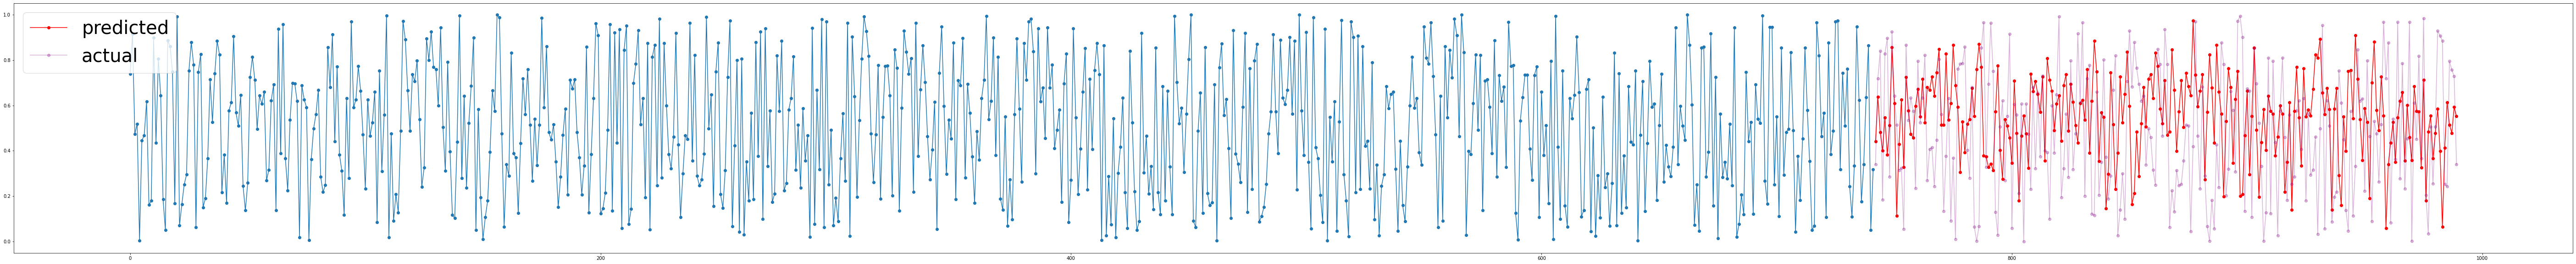

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') #Train데이터 그래프로 표현
plt.plot(y_2_axis, y_hat.reshape(len(x_test),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test.reshape(len(x_test),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=40)
plt.show()